# Car Prediction Assigment notebook


In [46]:
# global imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler, PowerTransformer, FunctionTransformer, MinMaxScaler
#import gradient boostring trees
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import sys
import os
from importlib import reload
import seaborn as sns
# config
# local imports

sys.path.append("\\".join(sys.path[0].split('\\')[:-1])+'\src')
print("\\".join(sys.path[0].split('\\')[:-1])+'\src')

import transformers as ct
import utils as ut
reload(ut)
reload(ct)
# get ehe path of the src folder relative to the current path
pd.set_option('display.max_columns', None)
from utils import normalize_prev_owner, fill_by_mean_mode_of_year, arabic_to_english, train_models, eval_models, hyper_parameter_training


c:\Users\nasser\Desktop\CAR\src


read the data from /data folder

In [47]:
car_data = pd.read_csv('../data/data.csv')


take a look at the data shape

In [48]:
car_data.shape


(6864, 16)

see the first 2 rows of the data

In [49]:
car_data.head(2)


,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,insurance_cost,sell_date
0,كيا اوبتيما,2014,100000,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,75000.0,4+1,يد اولى,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",3090,2017-08-16
1,كيا سورينتو,2007,60000,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500,130000.0,7+1,2,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",2740,2017-08-16


drop the insurance_cost column because its correlated with the price column

In [50]:
car_data.drop(columns=['insurance_cost'], inplace=True)


take a look at the data types of the columns

In [51]:
car_data.dtypes


car_name               object
year                    int64
price                   int64
color                  object
fuil_type              object
car_prev_state         object
license_country        object
transimission_type     object
glass_type             object
motor_power             int64
mileage               float64
passenger_capacity     object
prev_owners            object
additional_info        object
sell_date              object
dtype: object

<h1 align="center" style="color:yellow">Missing Values Handling</h1> 


draw a horizontal bar plot for the number of null values in each column

<AxesSubplot: >

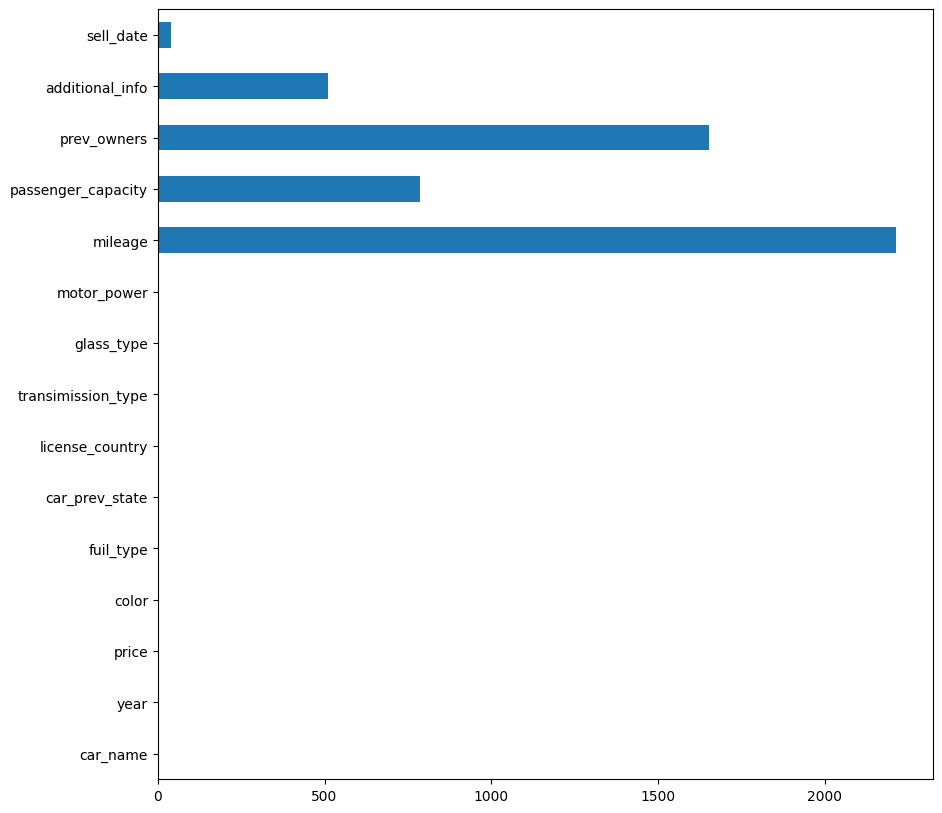

In [52]:
car_data.isnull().sum().plot(kind='barh', figsize=(10, 10))


fill the null values of the additional_info column with empty string ''
becouse if its null it means that there is no additional info

In [53]:
car_data['additional_info'].fillna('', inplace=True)


fill the null values for the sell_date with the ffill method (forward fill) becouse the data is nearly sorted by date and the null values are in the end of the data

In [54]:
car_data['sell_date'].fillna(method='ffill', inplace=True)


apply the function to the prev_owner column and convert it to int type 

the prev owner column is plain text so we need to convert it to int by applying the function to the column then we can fix the null values using the mean of the values for the same year model

In [55]:
# convert the prev_owners column to numeric if the function couldn't convert the value it will return NaN
car_data['prev_owners'] = car_data['prev_owners'].apply(normalize_prev_owner)


In [56]:
car_data['prev_owners'].unique()


array(['1', '2', nan, '0', '4', '3', '8', '6', '5', '9', '7', '159000',
       '12', '10', '11', '56', '13', '16', '17', '78888877766', '15',
       '170000', '18', '123423', '14', '12345', '1000', '778244', '19',
       '11111', '44444'], dtype=object)

fix the null values for the prev_owners column using the mean of the values for the same year model

In [57]:
car_data = car_data.apply(fill_by_mean_mode_of_year,
                          args=(car_data, 'prev_owners'), axis=1)


In [58]:
# we have 3 rows with NaN values in the prev_owners column after filling the missing values by the mean of the year
car_data[car_data['prev_owners'].isna()]
# so we will drop these rows


,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,sell_date
173,مرسيدس 200,1978,15000,ذهبي,بنزين,عمومي,فلسطينية,اوتوماتيك,يدوي,2000,NaN,4+1,NaN,"مسجل CD,جنطات مغنيسيوم",2017-09-24
3760,بي ام دبليو 320,1978,18000,ذهبي,بنزين,خصوصي,فلسطينية,عادي,يدوي,2000,0.0,4+1,NaN,"إغلاق مركزي,فتحة سقف,جنطات مغنيسيوم,فرش جلد",2020-08-02
4586,فولكسفاجن فينتو,1968,40000,أصفر,بنزين,خصوصي,فلسطينية,عادي,يدوي,1300,286000.0,NaN,NaN,فرش جلد,2021-04-15


In [59]:
car_data.dropna(subset=['prev_owners'], inplace=True)
car_data['prev_owners'] = car_data['prev_owners'].astype('int64')
car_data['prev_owners'].unique()


array([          1,           2,           0,           4,           3,
                 8,           6,           5,           9,           7,
            159000,          12,          10,          11,          18,
                56,          13,          16,          17, 78888877766,
                15,      170000,      123423,          14,       12345,
              1000,      778244,          19,       11111,       44444],
      dtype=int64)

In [60]:
car_data['passenger_capacity'].unique()


array(['4+1 ', '7+1 ', nan, '4+1  ', '5+1 ', '٤+١ ', '8 ', '6+1 ', '4+١ ',
       '٧ ', '7,+ 1 ', '7:1 ', '1+7 ', '١+٤ ', '2+1 ', '6+١ ', '+1 ',
       '6±١ ', '22 ', '1+1 ', '٥+١ ', '٧+1 ', '5+2 ', 'مثال: 4 + 1 ',
       '7.1 ', '7 =1 ', '٧+١ ', '6x1     ', '1+٤ ', '1+2 ', '4+1   ',
       '2/1 ', '8+1 ', '4+2 ', '٦+١ ', '2 ', '1٠4 ', '4\\١ ', '000 ',
       '3+1 ', '1 ', 'اكثر من 10 ', '9+1 '], dtype=object)

the passenger_capacity columns is meant to be int but it written as string equation so we need to convert it to int 

In [61]:
car_data['passenger_capacity'] = car_data['passenger_capacity'].apply(
    arabic_to_english)


In [62]:
car_data['passenger_capacity'].unique()


array([ 5.,  8., nan,  6.,  7.,  3.,  1.,  4.,  2.,  9.,  0., 10.])

to handle the missing values of the passenger_capacity column we will use the KNNImputer from sklearn.impute </br >
the KNNImputer will impute the missing values by using the k nearest neighbors found in the dataset  </br >
the reason we use the KNNImputer is becouse the KNN is based on the distance of the k nearest and this value is most likely to be the same as the similar cars </br > 

In [63]:
imputer = KNNImputer(n_neighbors=5,)
car_data['passenger_capacity'] = imputer.fit_transform(
    car_data[['passenger_capacity']])
car_data['passenger_capacity'] = car_data['passenger_capacity'].astype(int)


In [64]:
car_data[car_data['passenger_capacity'].isna()]


,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,sell_date


the mileage is numaric but have a alot of missing values so we will use the mean of the values for the same year model to fill the missing values 

In [65]:
# convert the mileage column to object to apply the convert_numbers function
car_data['mileage'] = car_data['mileage'].astype(object)
car_data = car_data.apply(fill_by_mean_mode_of_year,
                          args=(car_data, 'mileage'), axis=1)


In [66]:
car_data[car_data['mileage'].isna()]


,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,sell_date
345,فيات 127,1975,13000,أخضر,بنزين,خصوصي,فلسطينية,عادي,الكتروني,900,NaN,5,5,"جهاز إنذار,مسجل CD,جنطات مغنيسيوم,فرش جلد",2017-10-30
4247,فولكسفاجن جولف,1976,7000,أحمر,بنزين,خصوصي,فلسطينية,عادي,يدوي,1000,NaN,5,7,"مسجل CD,جنطات مغنيسيوم,فرش جلد",2020-12-17


In [67]:
car_data.dropna(subset=['mileage'], inplace=True)


In [68]:
car_data.isnull().sum()


car_name              0
year                  0
price                 0
color                 0
fuil_type             0
car_prev_state        0
license_country       0
transimission_type    0
glass_type            0
motor_power           0
mileage               0
passenger_capacity    0
prev_owners           0
additional_info       0
sell_date             0
dtype: int64

# Outliers 

take a look at the descriptive statistics of the numerical columns 

In [69]:
car_data.dtypes


car_name               object
year                    int64
price                   int64
color                  object
fuil_type              object
car_prev_state         object
license_country        object
transimission_type     object
glass_type             object
motor_power             int64
mileage               float64
passenger_capacity      int64
prev_owners             int64
additional_info        object
sell_date              object
dtype: object

array([[<AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'price'}>],
       [<AxesSubplot: title={'center': 'motor_power'}>,
        <AxesSubplot: title={'center': 'mileage'}>],
       [<AxesSubplot: title={'center': 'passenger_capacity'}>,
        <AxesSubplot: title={'center': 'prev_owners'}>]], dtype=object)

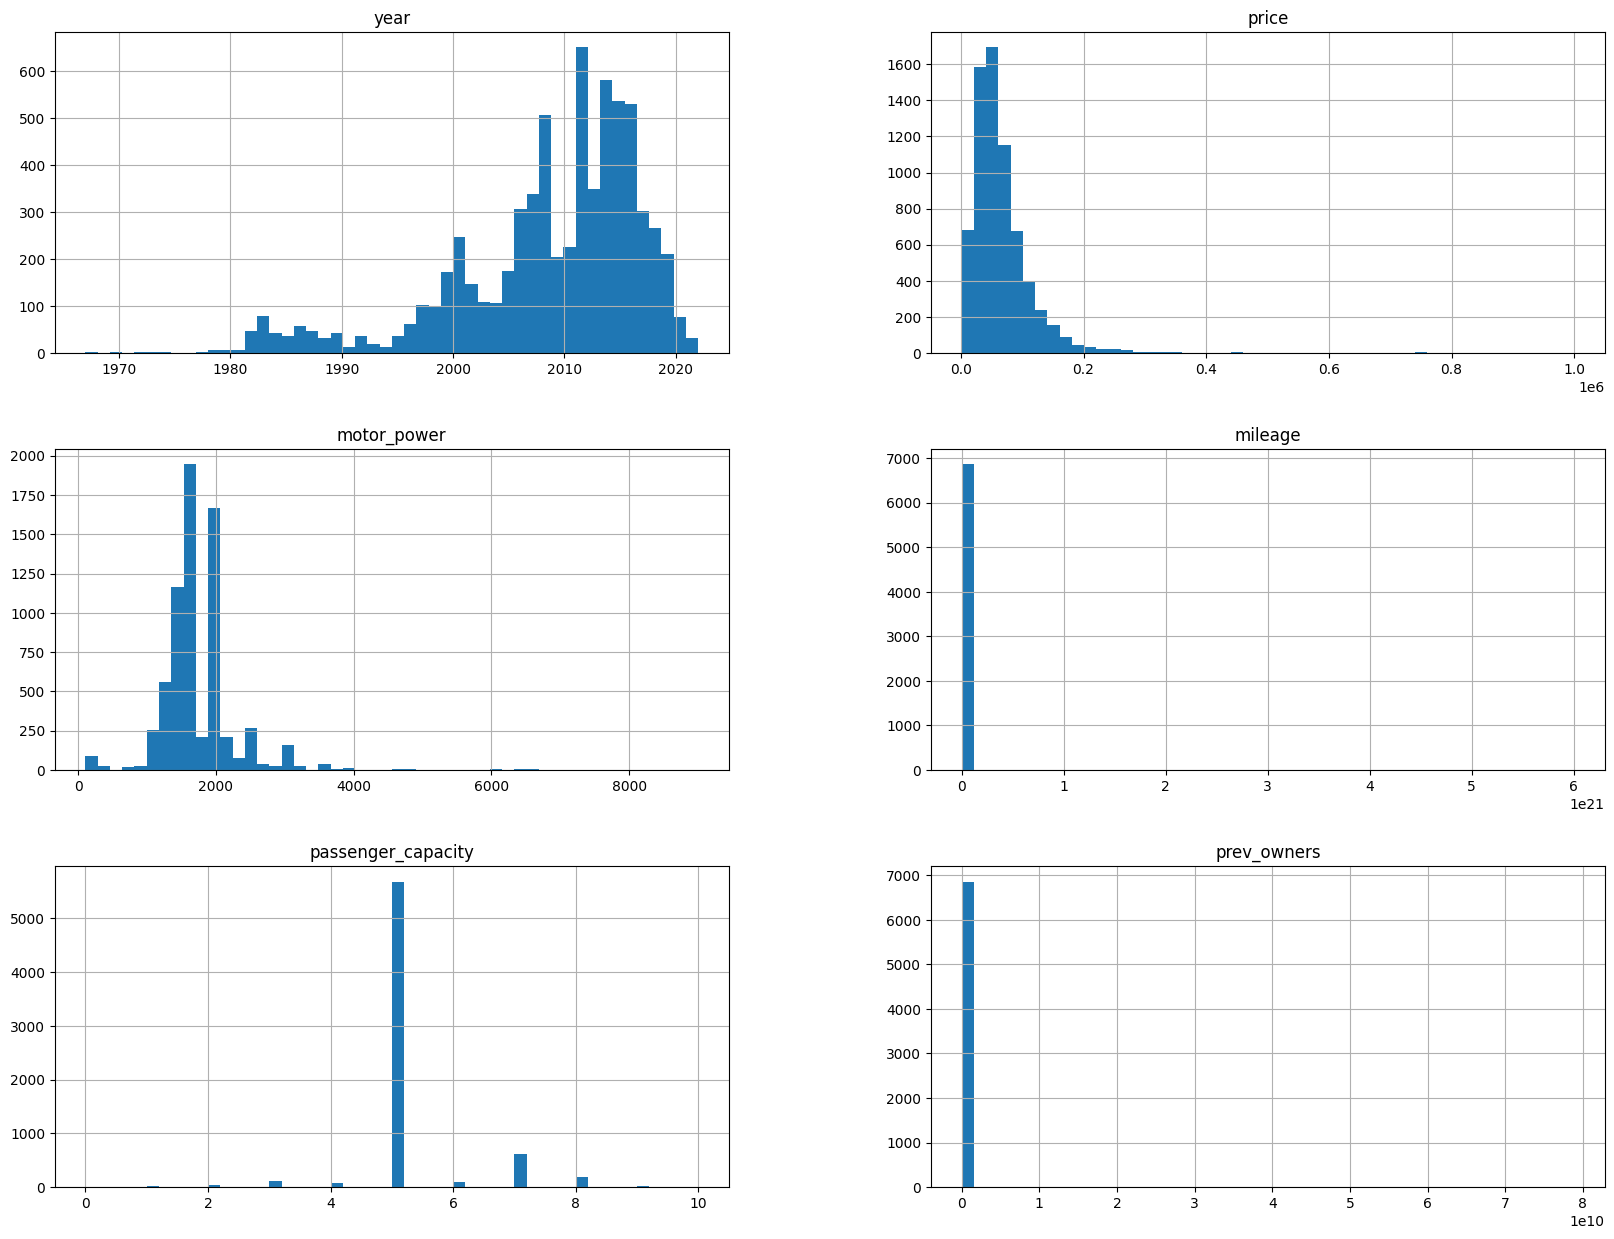

In [70]:
car_data.hist(bins=50, figsize=(20, 15))


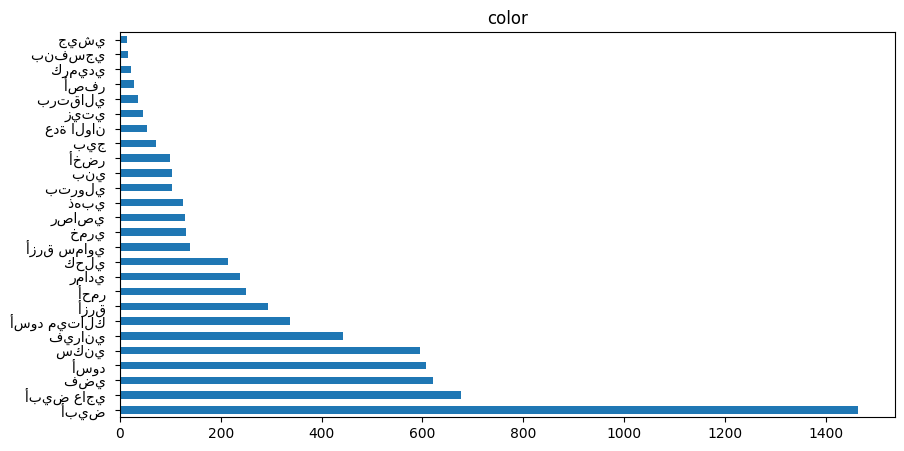

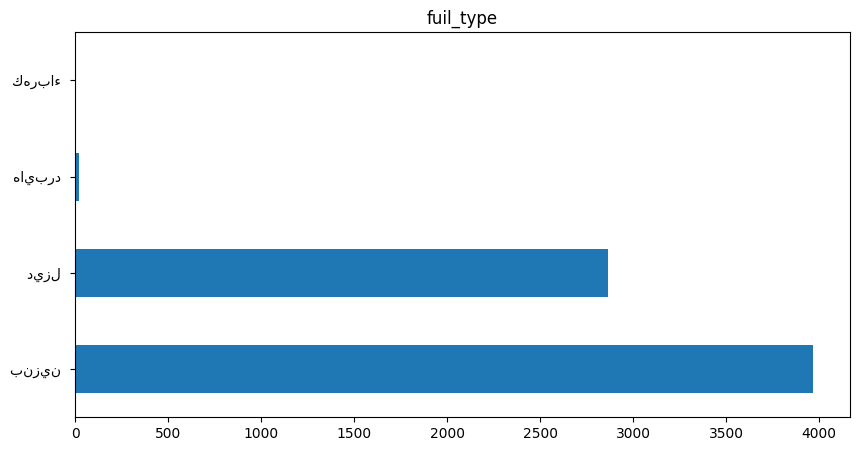

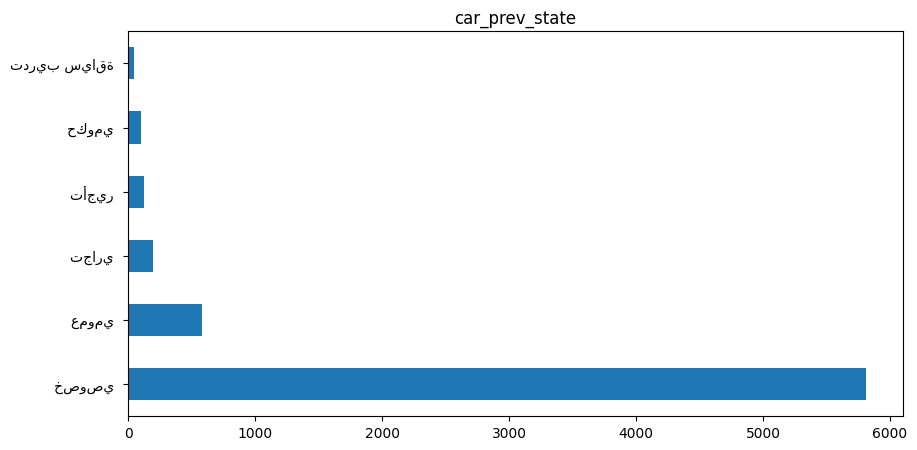

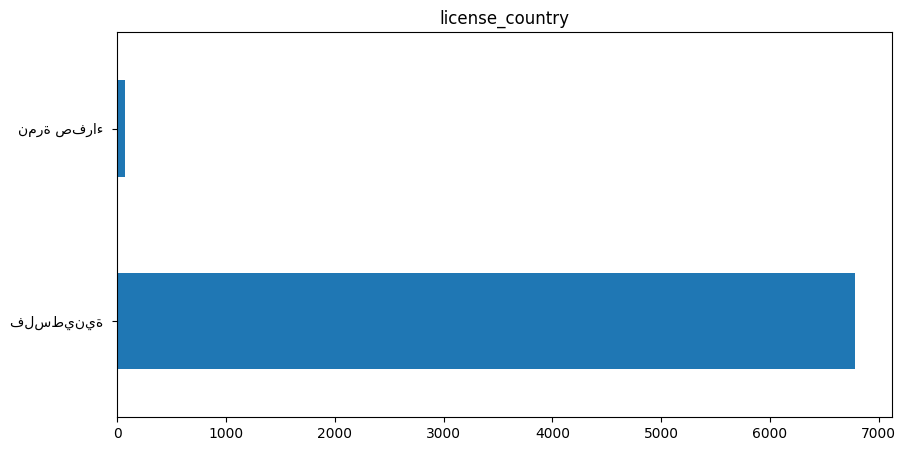

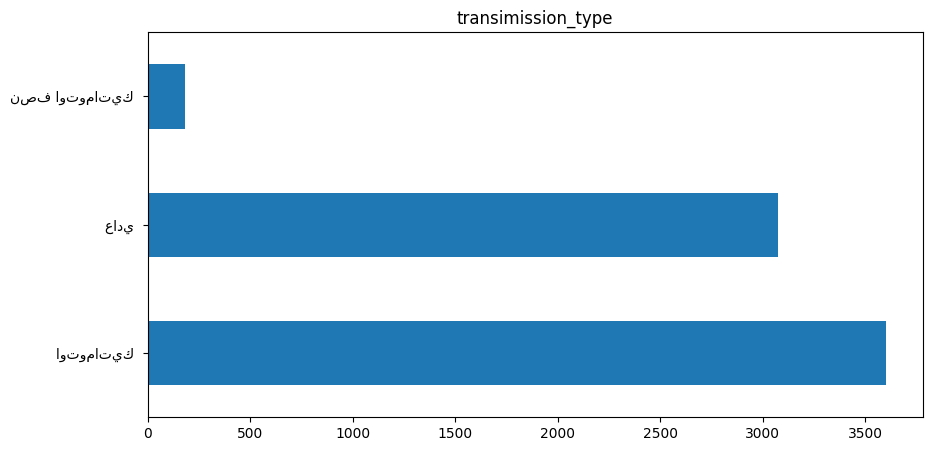

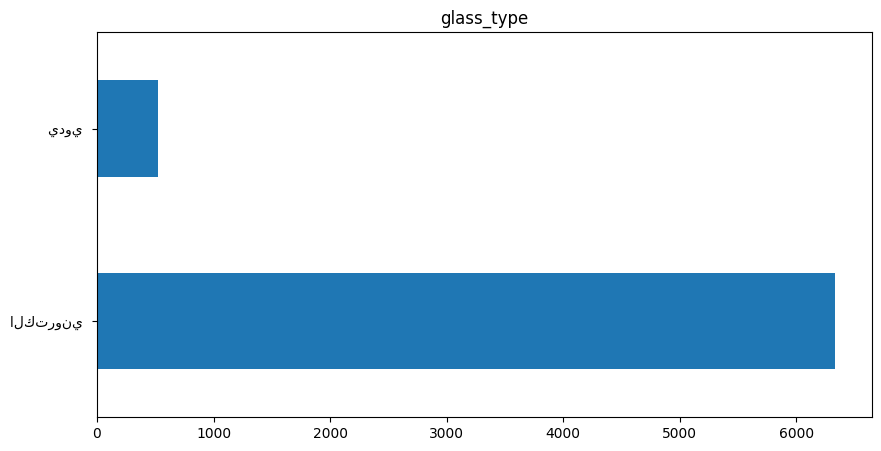

In [71]:
def draw_bar_plot(df, col):
    df[col].value_counts().plot(kind='barh', figsize=(10, 5))
    plt.title(col)
    plt.show()


exiclude_columns = ['car_name', 'prev_owners',
                    'additional_info', 'sell_date', 'passenger_capacity']
for col in car_data.columns:
    if car_data[col].dtype == 'object' and col not in exiclude_columns:
        draw_bar_plot(car_data, col)


In [72]:
car_data.describe()


,year,price,motor_power,mileage,passenger_capacity,prev_owners
count,6859.000000,6859.000000,6859.000000,6.859000e+03,6859.000000,6.859000e+03
mean,2008.616271,66756.614229,1740.080041,8.757646e+17,5.211401,1.150171e+07
std,8.659547,56848.387273,588.857086,7.253002e+19,0.899878,9.525447e+08
min,1967.000000,1111.000000,106.000000,0.000000e+00,0.000000,0.000000e+00
25%,2005.000000,36000.000000,1400.000000,0.000000e+00,5.000000,1.000000e+00
50%,2011.000000,55000.000000,1600.000000,3.900000e+04,5.000000,2.000000e+00
75%,2015.000000,82000.000000,2000.000000,1.000000e+05,5.000000,3.000000e+00
max,2022.000000,999999.000000,9000.000000,6.006870e+21,10.000000,7.888888e+10


compute the interquartile range (IQR) for each numerical column the IQR is the difference between the 75th and 25th percentile helps us to detect outliers

In [73]:

Q1 = car_data.quantile(0.25)
Q3 = car_data.quantile(0.75)
IQR = Q3 - Q1
IQR

C:\Users\nasser\AppData\Local\Temp\ipykernel_16468\3267955136.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = car_data.quantile(0.25)
C:\Users\nasser\AppData\Local\Temp\ipykernel_16468\3267955136.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = car_data.quantile(0.75)


year                      10.0
price                  46000.0
motor_power              600.0
mileage               100000.0
passenger_capacity         0.0
prev_owners                2.0
dtype: float64

compute the skewness of the numerical columns

In [74]:
car_data.skew()


C:\Users\nasser\AppData\Local\Temp\ipykernel_16468\2511782418.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  car_data.skew()


year                  -1.310555
price                  5.056875
motor_power            2.843267
mileage               82.819080
passenger_capacity     0.876538
prev_owners           82.819080
dtype: float64

remove the outliers from the numerical columns using the IQR method 

In [75]:
car_data['motor_power'].describe()
# remove the outliers rows from the motor_power column
car_data = car_data[~((car_data['motor_power'] < (Q1['motor_power'] - 1.5 * IQR['motor_power']))
                      | (car_data['motor_power'] > (Q3['motor_power'] + 1.5 * IQR['motor_power'])))]
# remove the outliers rows from the mile_age column
car_data = car_data[~((car_data['mileage'] < (Q1['mileage'] - 1.5 * IQR['mileage']))
                      | (car_data['mileage'] > (Q3['mileage'] + 1.5 * IQR['mileage'])))]
# remove the outliers rows from the insurance_cost column
car_data = car_data[~((car_data['prev_owners'] < (Q1['prev_owners'] - 1.5 * IQR['prev_owners']))
                      | (car_data['prev_owners'] > (Q3['prev_owners'] + 1.5 * IQR['prev_owners'])))]


In [76]:
car_data.shape

(5983, 15)

In [77]:
car_data.skew()


C:\Users\nasser\AppData\Local\Temp\ipykernel_16468\2511782418.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  car_data.skew()


year                 -1.437824
price                 5.637594
motor_power           0.401617
mileage               1.020911
passenger_capacity    1.774121
prev_owners           0.706748
dtype: float64

In [78]:
car_data['prev_owners'].describe()


count    5983.000000
mean        1.923115
std         1.334584
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: prev_owners, dtype: float64

In [79]:
car_data.describe()


,year,price,motor_power,mileage,passenger_capacity,prev_owners
count,5983.000000,5983.000000,5983.000000,5983.000000,5983.000000,5983.000000
mean,2009.385091,66366.738258,1682.591844,53359.008858,5.231489,1.923115
std,8.219152,52691.498025,360.086568,61993.666711,0.799781,1.334584
min,1967.000000,1111.000000,500.000000,0.000000,1.000000,0.000000
25%,2006.000000,37000.000000,1400.000000,0.000000,5.000000,1.000000
50%,2012.000000,55000.000000,1600.000000,33000.000000,5.000000,2.000000
75%,2015.000000,82000.000000,2000.000000,92000.000000,5.000000,3.000000
max,2022.000000,999999.000000,2900.000000,250000.000000,10.000000,6.000000


# Feature Engineering 

all features extraction and above feature transformation incapsulated in a custom transformers  found in src/transformers.py to be used in the pipeline </br>
the transformers are: </br>
- DateTransformer: extract the year from the sell_date column </br>
- PrevOwnerTransformer : extract the number of previous owners from the prev_owner column  and handle the missing values after the extraction </br>
- PassengerCpacityTransformer : extract the passenger capacity from the passenger_capacity column and handle the missing values after the extraction </br>
- NominalTransformer : using the one hot encoder to encode the nominal columns </br>
- OrdenalTransformer : using the label encoder to encode the ordinal columns  based on given order </br>
- ColorTransformer : delete the color column becouse it has alot of unique values and it will make the model overfit </br>
- AdditionalInfoTransformer : using the one hot encoder to encode the additional_info column </br>



In [80]:
car_data.columns


Index(['car_name', 'year', 'price', 'color', 'fuil_type', 'car_prev_state',
       'license_country', 'transimission_type', 'glass_type', 'motor_power',
       'mileage', 'passenger_capacity', 'prev_owners', 'additional_info',
       'sell_date'],
      dtype='object')

In [81]:
nomenal_features = ['fuil_type', 'transimission_type',
                    'glass_type', 'car_prev_state', 'license_country', 'color']


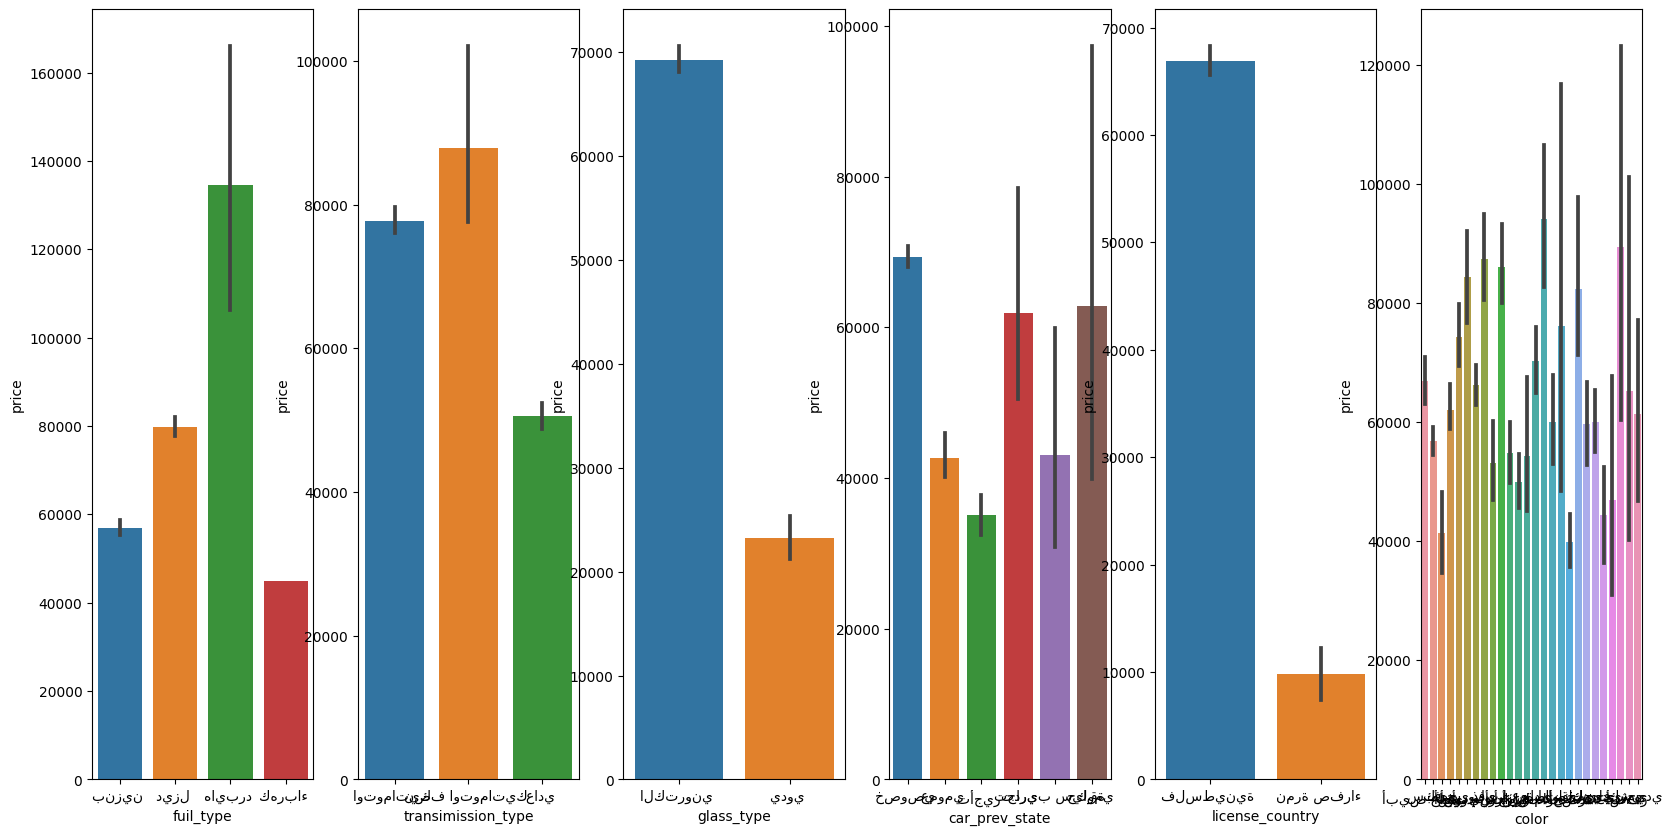

In [82]:


plt.figure(figsize=(20, 10))
for index, feature in enumerate(nomenal_features):
    plt.subplot(1, len(nomenal_features), index+1)
    sns.barplot(x=feature, y='price', data=car_data)
    # the arabic text is flipped so i used this code to fix it


<AxesSubplot: xlabel='color', ylabel='price'>

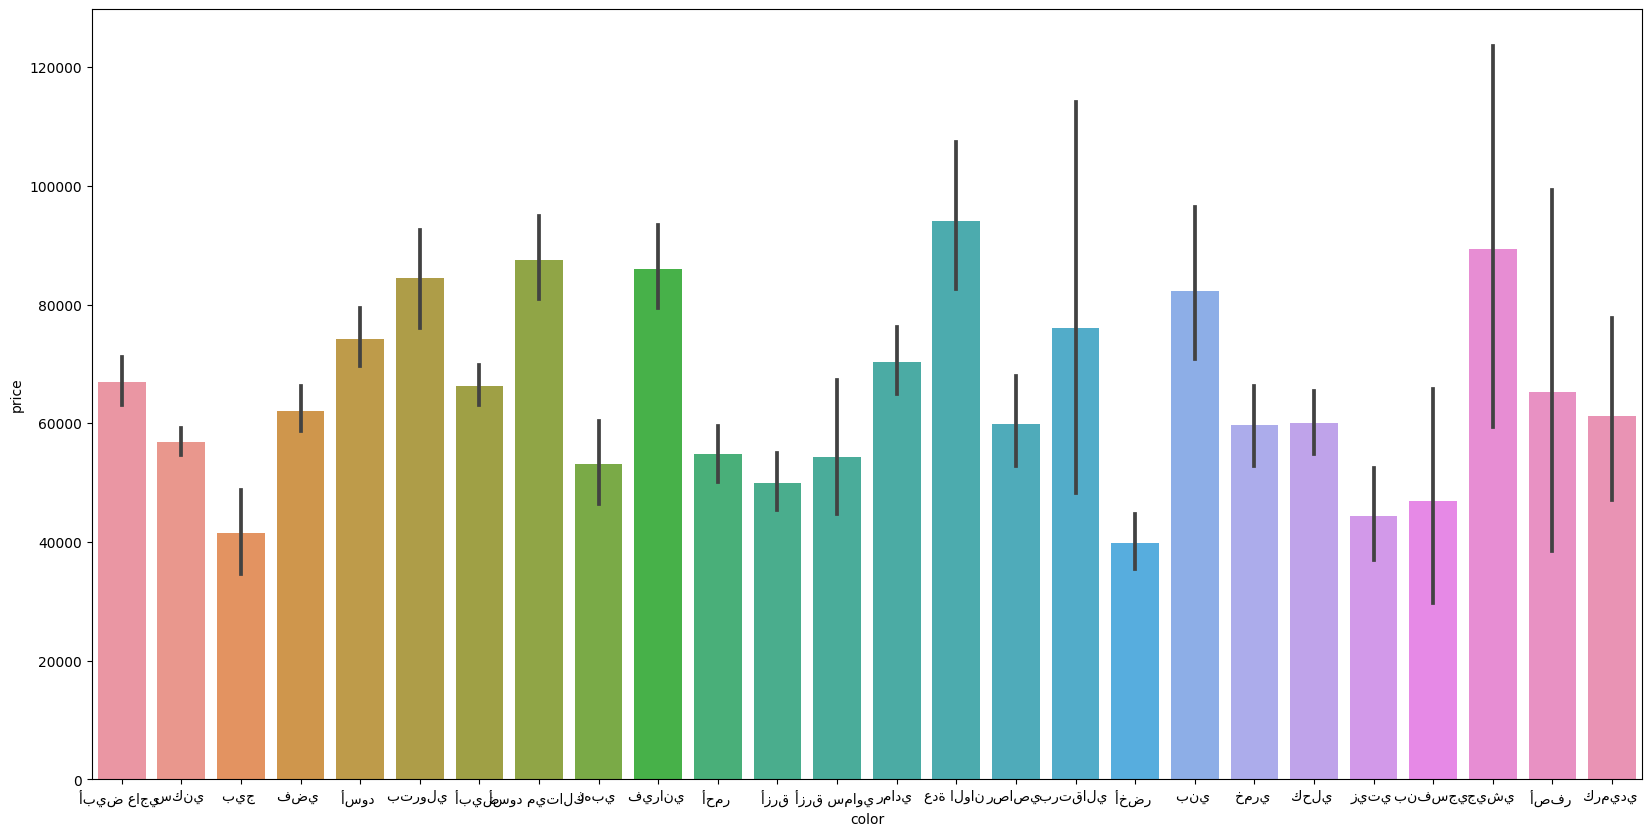

In [83]:
# see if the color has effect on the price or not
plt.figure(figsize=(20, 10))
sns.barplot(x='color', y='price', data=car_data)


# Hyperparameter Tuning ! Using GridSearchCV 

In [84]:
x_train, x_test, y_train, y_test = train_test_split(car_data.drop(
    'price', axis=1), car_data['price'], test_size=0.33, random_state=41)
base_steps = [("Date Transform", ct.DateTransformer(column='sell_date')),
              ("Prev_owner Transformer", ct.PrevOwnerTransformer(column='prev_owners')),
              ("Passenger Capacity Transformer",
               ct.PassengerCpacityTransformer(column='passenger_capacity')),
              ("Car Name Transformer", ct.CarNameTransformer(column='car_name')),
              ("Nominal Transformer", ct.NominalTransformer(
                  columns=nomenal_features + ['company_name'])),
              ("Additional Info Transformer",
               ct.AdditionalInfoTransformer(column='additional_info')),
              ]


In [85]:
models = {
    # "Linear Regression": {
    #     "steps": base_steps + [("Polynomial Features", PolynomialFeatures()), ("Linear Regression", LinearRegression())],
    #     "grid_vals": {'Polynomial Features__degree': [1, 2]}
    # },
    # "Ridge Regression": {
    #     "steps": base_steps + [("Polynomial Features", PolynomialFeatures()), ("Ridge Regression", Ridge())],
    #     "grid_vals": {'Polynomial Features__degree': [1, 2], 'Ridge Regression__alpha':[0.001, 0.01, 0.1, 1]}},
    # "Lasso Regression": {
    #     "steps": base_steps + [("Polynomial Features", PolynomialFeatures()), ("Lasso Regression", Lasso())],
    #     "grid_vals": {'Polynomial Features__degree': [1, 2], 'Lasso Regression__alpha': [ 0.001, 0.01, 0.1, 1]}},
    # "Knn Regression": {
    #     "steps": base_steps + [("Knn Regression", KNeighborsRegressor())],
    #     "grid_vals": {'Knn Regression__n_neighbors':  [3, 5, 7, 9]}},
    # "Decision Tree Regression": {
    #     "steps": base_steps + [("Decision Tree Regression", DecisionTreeRegressor())],
    #     "grid_vals": {'Decision Tree Regression__max_depth':[3, 5, 7, 9,None]}},
    "gradient Boosting Regression": {
        "steps": base_steps + [("gradient Boosting Regression", GradientBoostingRegressor())],
        "grid_vals": {'gradient Boosting Regression__n_estimators': [100, 200, 300, 400, 500], 
                      'gradient Boosting Regression__max_depth': [3, 5, 7, 9, None],
                      'gradient Boosting Regression__max_features': [7, 9, 11, 13, 15, 17, 19]
                      }},
}


In [86]:
models = hyper_parameter_training(models, x_train.copy(), y_train.copy())

Training the model gradient Boosting Regression 


In [87]:
for model_name, model in models.items():
    print(f"{model_name},{model['model'].best_score_},{model['model'].best_params_}")

gradient Boosting Regression,0.4944337611201668,{'gradient Boosting Regression__max_depth': 3, 'gradient Boosting Regression__max_features': 11, 'gradient Boosting Regression__n_estimators': 200}


In [90]:
pip = Pipeline(steps=base_steps+ [("gradient Boosting Regression", GradientBoostingRegressor(max_depth=3,max_features=11,n_estimators=200))])
pip.fit(x_train.copy(), y_train.copy())
print(f"Train Score: {pip.score(x_train.copy(), y_train.copy())}")
print(f"Test Score: {pip.score(x_test.copy(), y_test.copy())}")

Train Score: 0.6447331090348849
Test Score: 0.453745876536632


In [89]:
import pickle
pickle.dump(pip, open('../models/gradient_Boosting_Regression.pkl', 'wb'))
